# Import modules


In [5]:
from pathlib import Path
from pprint import pprint
import numpy as np
import h5py

from toolbox import imshow, run_sense

# Read data


In [3]:
data_root = Path().resolve().parent / "Data"
with h5py.File(data_root / "data1.h5", "r") as f:
    print("Keys")
    pprint(list(f.keys()))

    grappa = f["grappa"][()]  # GRAPPA reconstructed image from kdata_raw192
    kdata_fs = f["kdata_fs"][()]  # fully-sampled k-space data using GRAPPA
    kdata_us = f["kdata_raw"][()]  # under-sampled k-space data
    sens_maps = f["sm_espirit"][()]  # sensitivity maps generated using ESPIRiT

    print(f"grappa shape: {grappa.shape}")  # (y(PE), x(RO), slice)
    print(f"kdata_fs shape: {kdata_fs.shape}")  # (coil, y(PE), x(RO), slice)
    print(f"kdata_us shape: {kdata_us.shape}")  # (coil, y(PE), x(RO), slice)
    print(f"sens_maps shape: {sens_maps.shape}")  # (coil, y(PE), x(RO), slice)

Keys
['grappa', 'kdata_fs', 'kdata_raw', 'sm_espirit']
grappa shape: (480, 384, 58)
kdata_fs shape: (30, 480, 384, 58)
kdata_us shape: (30, 480, 384, 58)
sens_maps shape: (30, 480, 384, 58)


# SENSE reconstruction of the undersampled data


In [7]:
kdata_us_tp = np.transpose(kdata_us, (3, 0, 1, 2))  # (slice, coil, y(PE), x(RO))
sens_maps_tp = np.transpose(sens_maps, (3, 0, 1, 2))  # (slice, coil, y(PE), x(RO))
lamda = 0.01
max_iter = 30
recon_sense = run_sense(kdata_us_tp, sens_maps_tp, lamda=lamda, max_iter=max_iter)

[09:36:38]   - SENSE reconstruction
[09:36:38]     - lamda: 0.01, max_iter: 30


SENSE reconstruction: 100%|██████████| 58/58 [00:20<00:00,  2.85it/s]


# Function: imshow
- `imgs` parameter takes list of images. `List comprehension` works beautifully with it. 

## $k$-space visualization
- For $k$-space visualization, set `norm` parameter between 0.2 ~ 0.5

kdata_fs shape: (30, 480, 384, 58)
kdata_us shape: (30, 480, 384, 58)


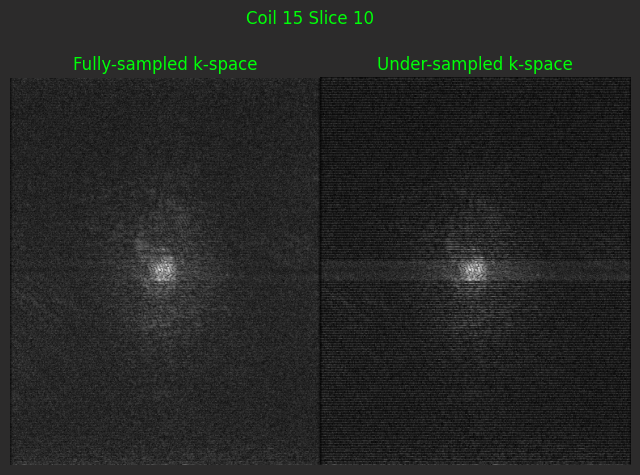

In [31]:
print(f"kdata_fs shape: {kdata_fs.shape}")  # (coil, y(PE), x(RO), slice)
print(f"kdata_us shape: {kdata_us.shape}")  # (coil, y(PE), x(RO), slice)

slice_idx = 10
coil_idx = 15
imshow([i[coil_idx, ..., slice_idx] for i in [kdata_fs, kdata_us]], titles=['Fully-sampled k-space', 'Under-sampled k-space'], suptitle=f'Coil {coil_idx} Slice {slice_idx}', norm=0.5)


## single slice visualization


grappa_tp shape: (58, 480, 384)
recon_sense shape: (58, 480, 384)


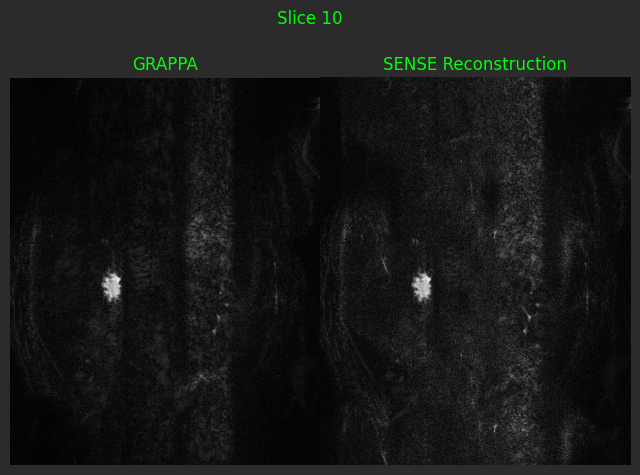

In [10]:
grappa_tp = np.transpose(grappa, (2, 0, 1))  # (slice, y(PE), x(RO))

print(f"grappa_tp shape: {grappa_tp.shape}")  # (slice, y(PE), x(RO))
print(f"recon_sense shape: {recon_sense.shape}")  # (slice, y(PE), x(RO))

slice_idx = 10
imshow([grappa_tp[slice_idx], recon_sense[slice_idx]], titles=['GRAPPA', 'SENSE Reconstruction'], suptitle=f'Slice {slice_idx}', norm=.8)

## Maximum intensity projection (MIP) visualizaion

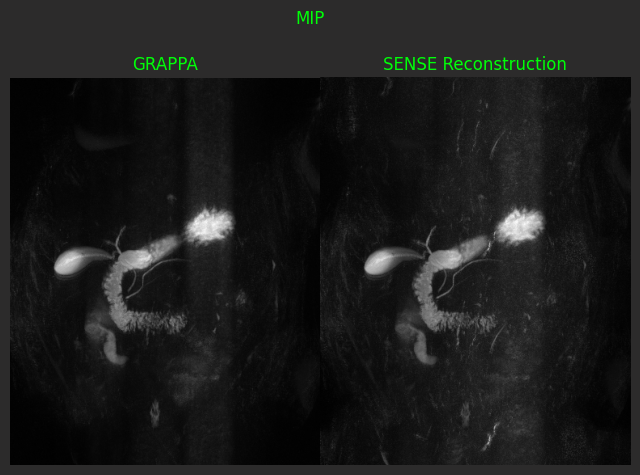

In [11]:
imshow([grappa_tp, recon_sense], titles=['GRAPPA', 'SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0)

### Crop the image view
- For the custom crop fucntion, define your function and pass it to `crop_fn`

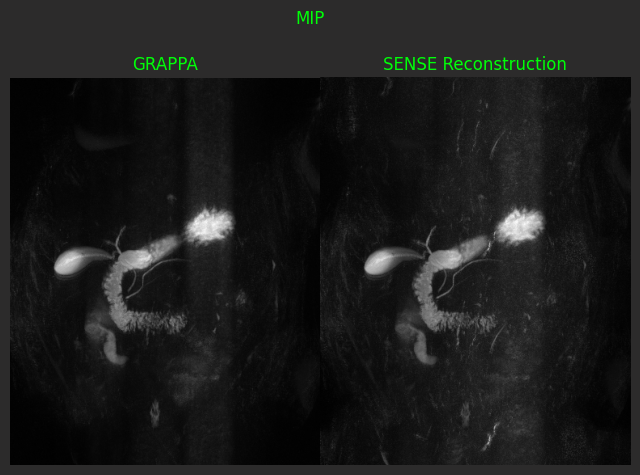

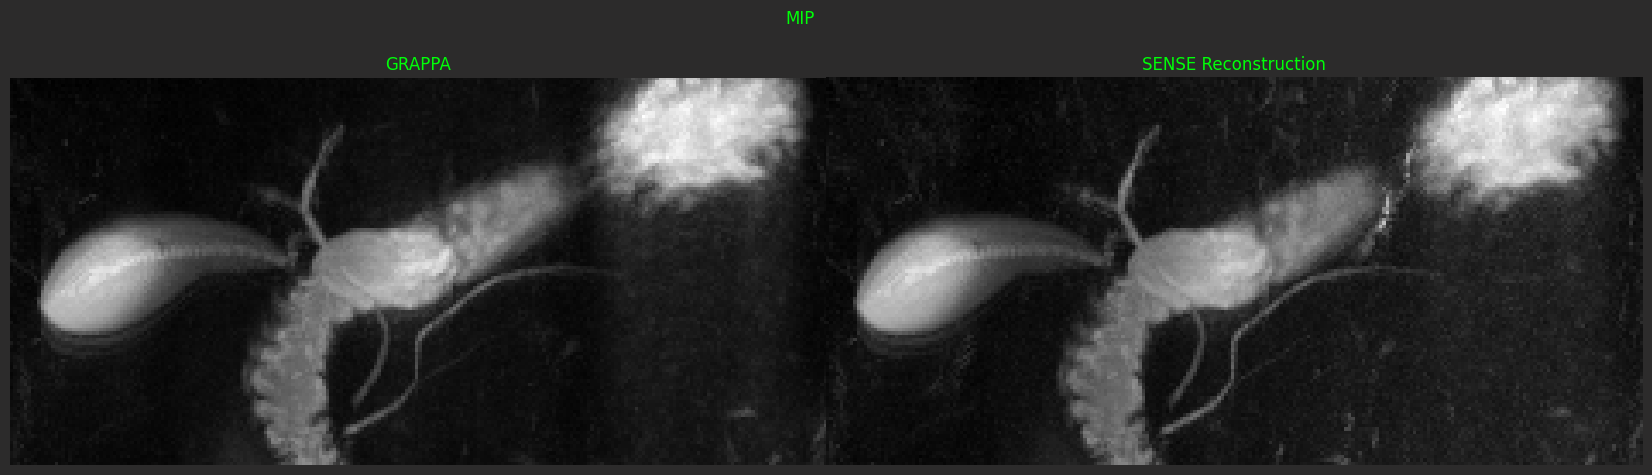

In [28]:
'''
x0, y0: starting point
x1, y1: width and height
'''
x0, y0, width, height = ((46, 170, 238, 113)) 
crop_fn = lambda x: x[..., y0 : y0 + height, x0 : x0 + width]


imshow([grappa_tp, recon_sense], titles=['GRAPPA', 'SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0)
imshow([grappa_tp, recon_sense], titles=['GRAPPA', 'SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, crop_fn=crop_fn)

## Use of hook_fn

There are multiple predefined hook in this toolbox. 
- MetricScores
  - Calculate metric scores of `imgs` agains `gt` of the first image in `imgs`. The metric scores are calculated based on 2D images. 
- VolumeMetricScores
  - Calculate metric scores of `imgs` agains `gt` of the first image in `imgs`. The metric scores are calculated based on 3D images. 
- DrawBox
  - Draw box on the image. This works well with custom crop function.
- LineProfile
  - Plot line profile on the image.

In [38]:
from toolbox import imshow_hooks

print(imshow_hooks.__doc__)


Copyright (c) 2025 Jinho Kim (jinho.kim@fau.de)

Modifications and additional features by Jinho Kim are licensed under the MIT
license, as detailed in the accompanying LICENSE file.

- MetricScores
    - percentile = False
    - p = 98
    - metrics = ["psnr", "ssim]
- VolumeMetricScores
    - percentile = False
    - p = 98
    - metrics = ["psnr", "ssim]
- DrawBox
    - box_coords = None
    - box_linewidth = 2
    - box_edgecolor = red
- LineProfile
    - profile_coords = None
    - plot_fig_size = (6, 6)
    - legend_loc = upper right
    - metric_on = True
    - linewidth = 1
    - arrow_color = green

** None should be replaced with the actual values.



### VolumeMetricScores example
- Parameters:
    - percentile = False
    - p = 98
    - metrics = ["psnr", "ssim]

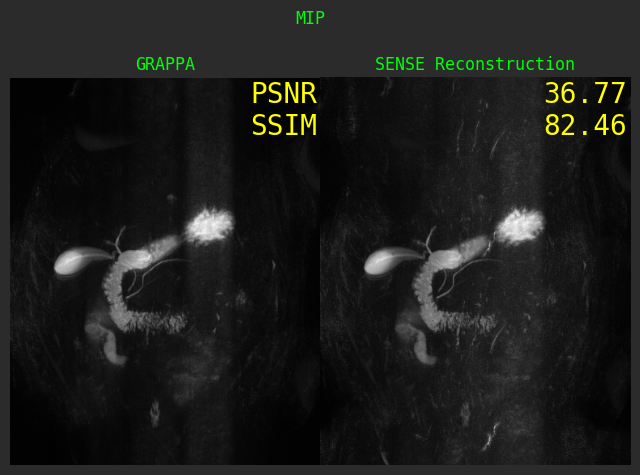

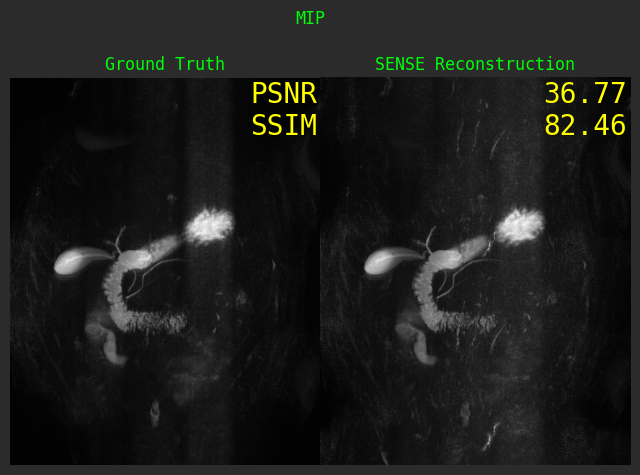

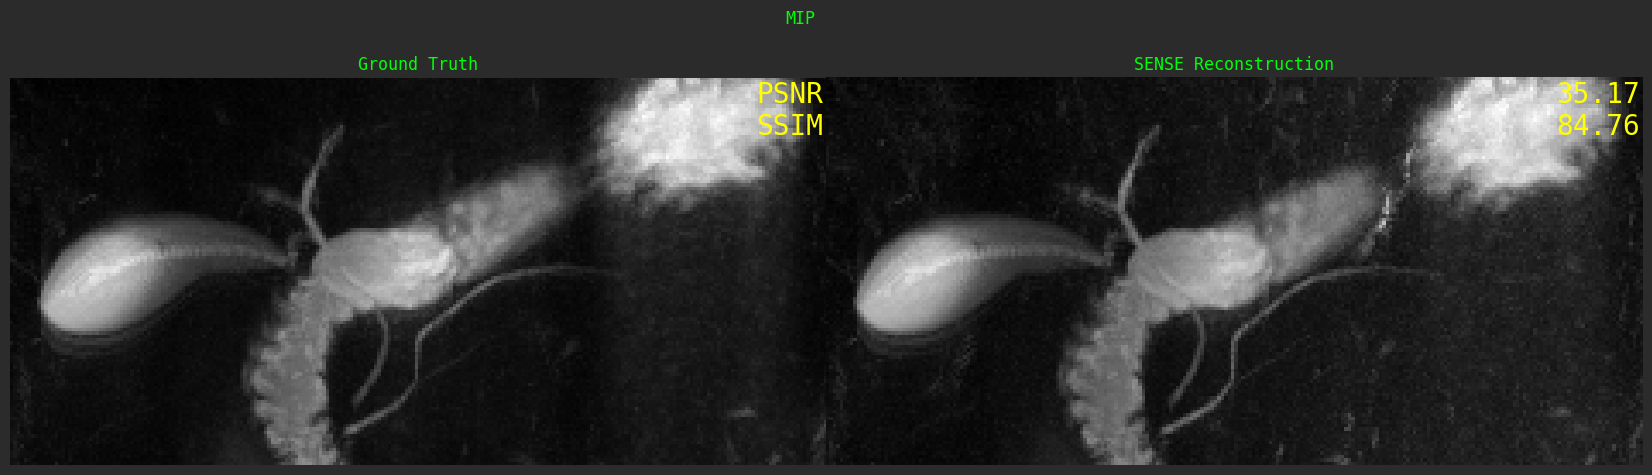

In [ ]:
hook_fn = ['VolumeMetricScores']

imshow([grappa_tp, recon_sense], titles=['GRAPPA', 'SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, hook_fns=hook_fn)
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, hook_fns=hook_fn)


x0, y0, width, height = ((46, 170, 238, 113)) 
crop_fn = lambda x: x[..., y0 : y0 + height, x0 : x0 + width]
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, hook_fns=hook_fn, crop_fn=crop_fn)

### DrawBox example
- Parmeters
  - box_coords = None
  - box_linewidth = 2
  - box_edgecolor = red

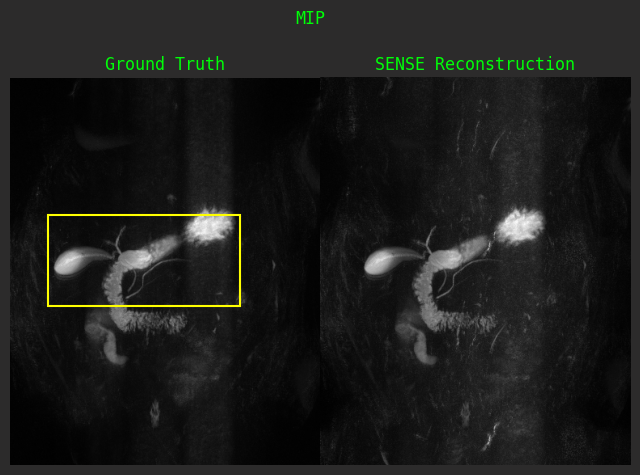

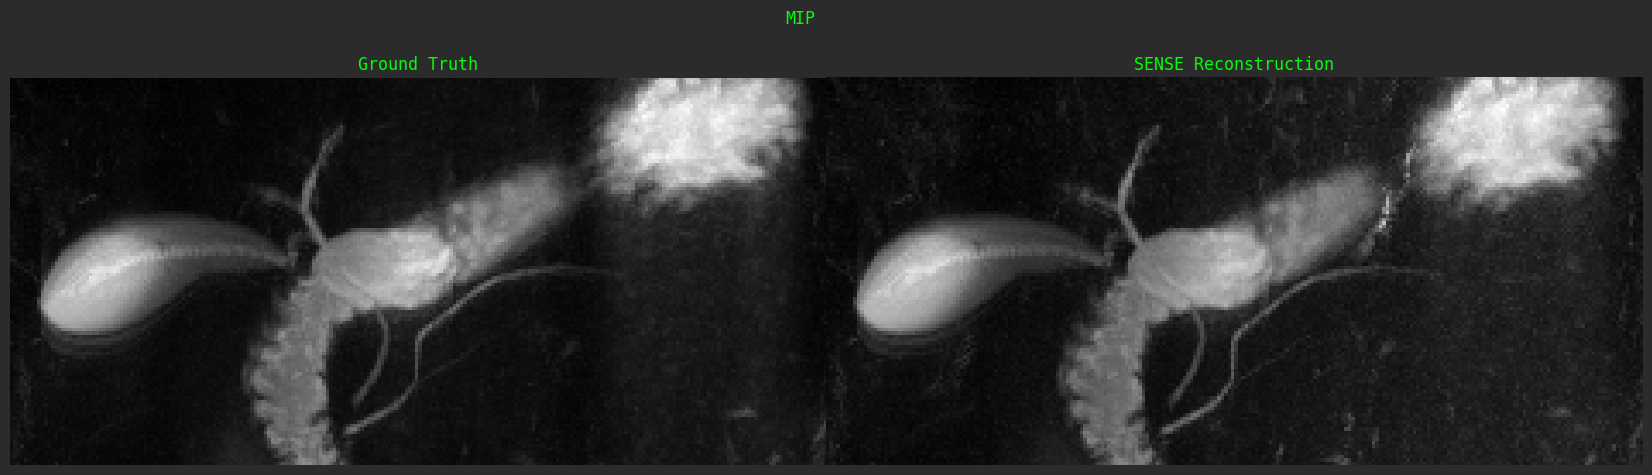

In [40]:
box_coords = ((46, 170, 238, 113)) 
x0, y0, width, height = box_coords
crop_fn = lambda x: x[..., y0 : y0 + height, x0 : x0 + width]

box_linewidth = 1.5
box_edgecolor = 'yellow'

hook_fn = [("DrawBox", {'box_coords': box_coords, 'box_linewidth': box_linewidth, 'box_edgecolor': box_edgecolor})]
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, hook_fns=hook_fn)
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, crop_fn=crop_fn)


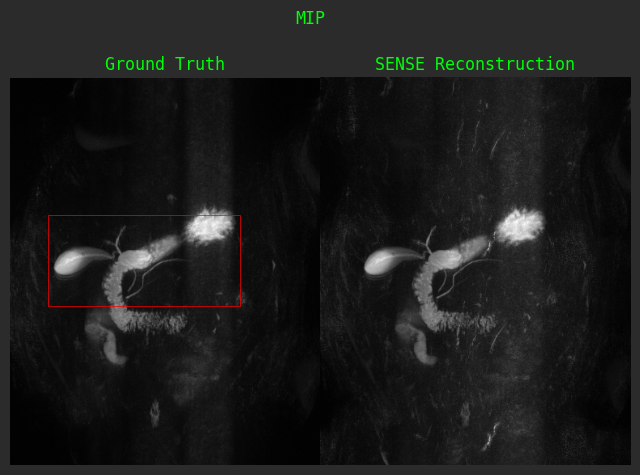

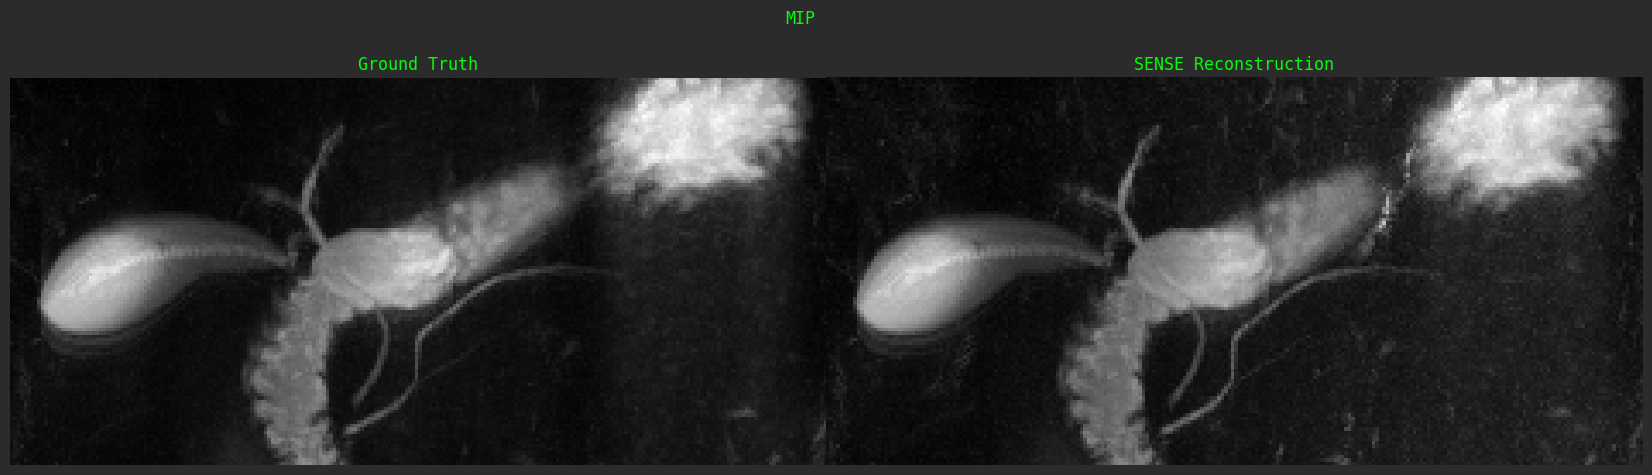

In [41]:
box_coords = ((46, 170, 238, 113)) 
x0, y0, width, height = box_coords
crop_fn = lambda x: x[..., y0 : y0 + height, x0 : x0 + width]

box_linewidth = 0.5
box_edgecolor = 'red'

hook_fn = [("DrawBox", {'box_coords': box_coords, 'box_linewidth': box_linewidth, 'box_edgecolor': box_edgecolor})]
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, hook_fns=hook_fn)
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, crop_fn=crop_fn)


### LineProfile example

- Parameters:
  - profile_coords = None
  - plot_fig_size = (6, 6)
  - legend_loc = upper right
  - metric_on = True
  - linewidth = 1
  - arrow_color = green

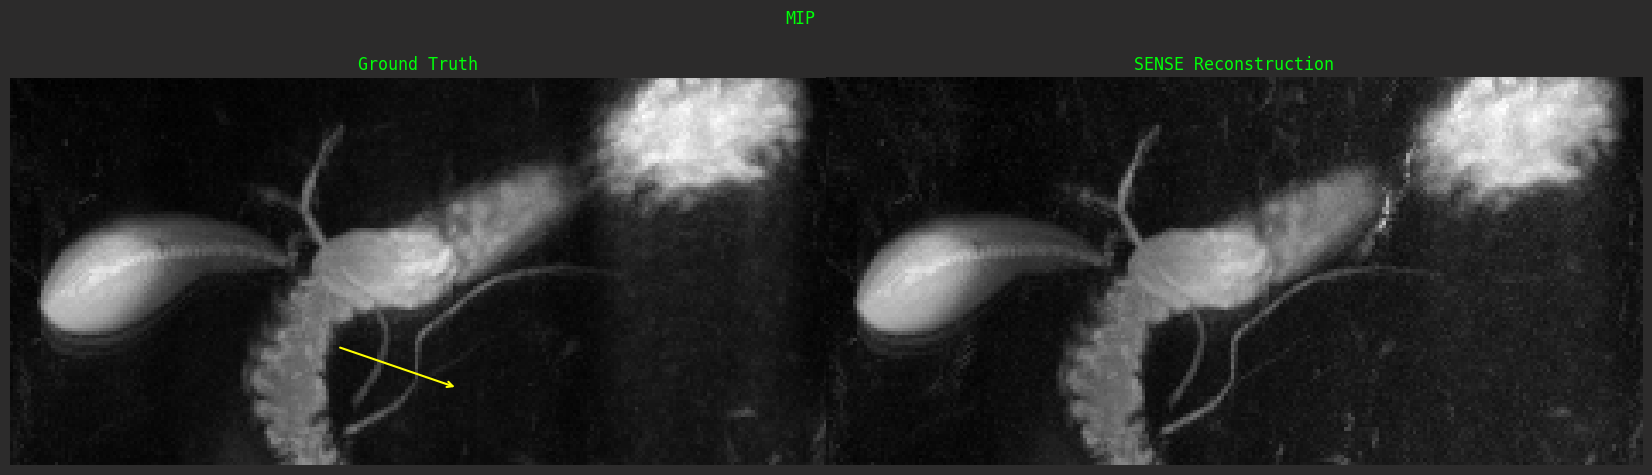

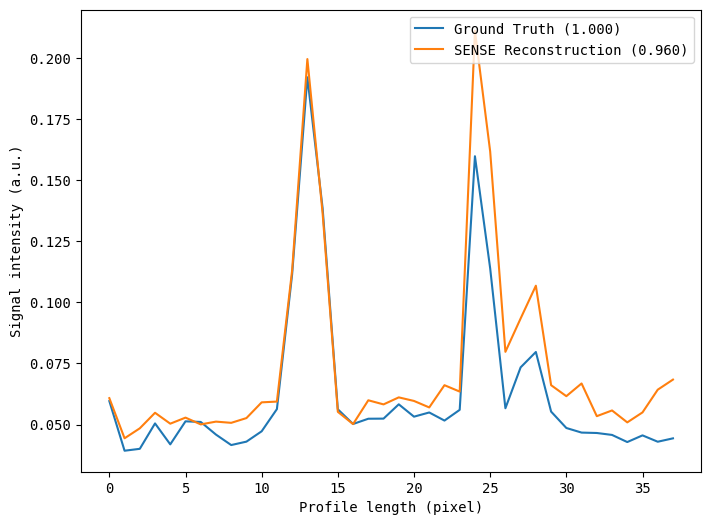

In [ ]:
'''
x0, y0: starting point
x1, y1: ending point
'''
line_coords = ((95, 78, 130, 90)) # Define line coordinates (x0, y0, x1, y1)

box_coords = ((46, 170, 238, 113)) 
x0, y0, width, height = box_coords
crop_fn = lambda x: x[..., y0 : y0 + height, x0 : x0 + width]

hook_fn = [("LineProfile", {'profile_coords': line_coords})]
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, hook_fns=hook_fn, crop_fn=crop_fn)


## Save figures

To save figures, 
- set `fname` parameter with desired file name. 
- `root` parameter is optional, default is current working directory. 
- `save_indiv` parameter saves individual images when `imgs` has multiple images.

The figures are saved in `root/Figures`. 

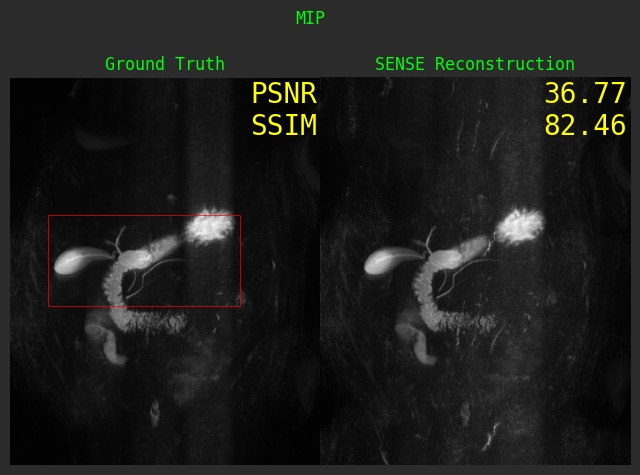

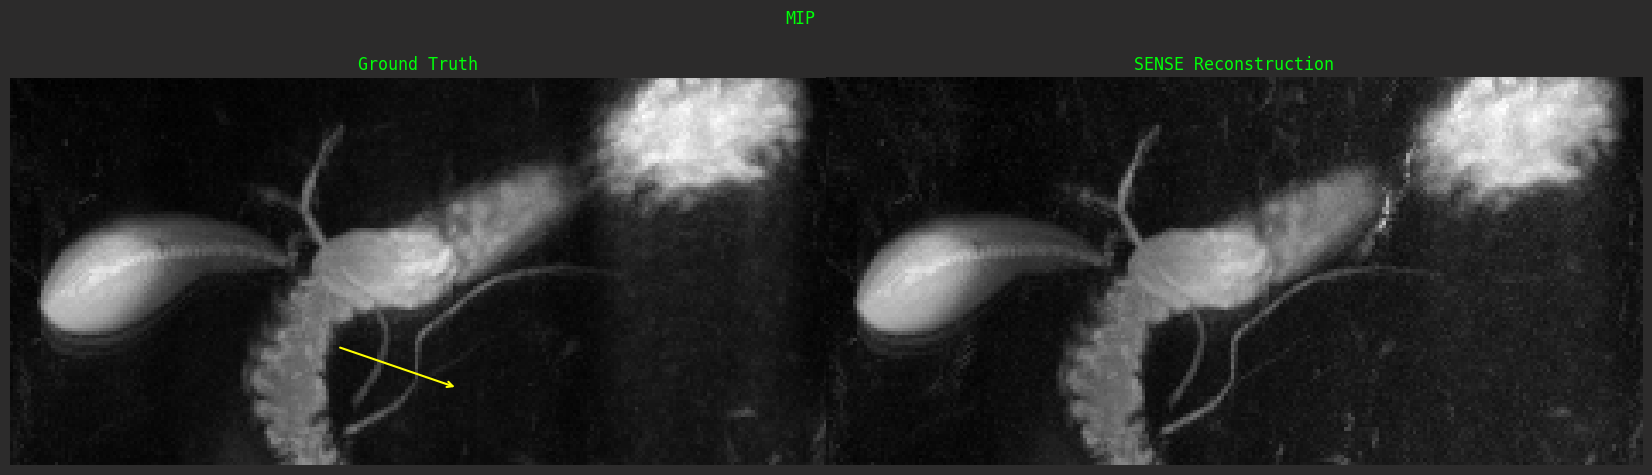

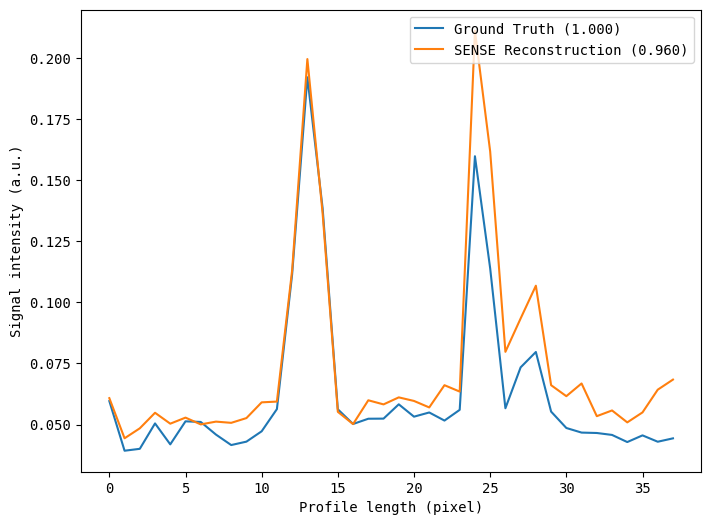

In [ ]:
box_coords = ((46, 170, 238, 113)) 
x0, y0, width, height = box_coords
crop_fn = lambda x: x[..., y0 : y0 + height, x0 : x0 + width]

box_linewidth = 0.5
box_edgecolor = 'red'

line_coords = ((95, 78, 130, 90)) # Define line coordinates (x0, y0, x1, y1)

hook_fn = ['VolumeMetricScores', ("DrawBox", {'box_coords': box_coords, 'box_linewidth': box_linewidth, 'box_edgecolor': box_edgecolor})]
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, hook_fns=hook_fn, fname="Demo_Figure", save_indiv=True)

hook_fn2 = [("LineProfile", {'profile_coords': line_coords})]
imshow([recon_sense], gt = grappa_tp, titles=['SENSE Reconstruction'], suptitle=f'MIP', norm=.8, is_MIP=True, MIP_axes=0, hook_fns=hook_fn2, crop_fn=crop_fn, fname="Demo_Figure_(Cropped)", save_indiv=True)


'''
Figures are saved in "./Demo/Figures/"
'''

# Function: inter_imshow

This function is an example of interactive visualization using `ipywidgets`. You can define your own inter_fn to customize the interactivity.

In [64]:
from toolbox import inter_imshow

inter_imshow([grappa_tp, recon_sense], titles=['GRAPPA', 'SENSE Reconstruction'], suptitle='Interactive MIP Visualization')

interactive(children=(IntSlider(value=15, description='slice_num', max=57), FloatSlider(value=0.7, description…